In [146]:
import pandas as pd
from transformers import AutoTokenizer,DataCollatorWithPadding,Trainer,EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification, TrainingArguments,SchedulerType
from transformers import trainer_utils
from transformers.trainer_utils import IntervalStrategy as SaveStrategy
from datasets import load_dataset
from datasets import Dataset, DatasetDict
import torch
from torch.serialization import add_safe_globals
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import math
import ipywidgets
import os
from matplotlib import colors as mcolors
from scipy.stats import binomtest




In [147]:
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()

In [148]:
import sys, torch
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
import transformers; print("Transformers:", transformers.__version__, transformers.__file__)
import subprocess; subprocess.run([sys.executable, "-m", "pip", "show", "transformers"])

Python: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
PyTorch: 2.7.0
Transformers: 4.55.0 /home/ubuntu/.local/lib/python3.10/site-packages/transformers/__init__.py
Name: transformers
Version: 4.55.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'show', 'transformers'], returncode=0)

In [149]:
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)

PyTorch version: 2.7.0
Transformers version: 4.55.0


In [150]:
print(torch.version.cuda)         # CUDA version PyTorch was built with
print(torch.backends.cudnn.version())  # cuDNN version
print(torch.cuda.is_available())

12.8
90800
True


In [151]:
print("torch.version.cuda:", torch.version.cuda)       # None on CPU build
print("torch.cuda.is_available():", torch.cuda.is_available())  # False
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

torch.version.cuda: 12.8
torch.cuda.is_available(): True
CUDA_VISIBLE_DEVICES: None


### VIZ

In [152]:
# === Training cycle visualizations (fresh start run) ===
# Edit these two paths to match your environment:
MODEL_DIR = "./hatebert_fresh_linear_try1/checkpoint-4000"                 # folder that contains trainer_state.json
csv_path = "./eval_exports/test_raw_predictions_with_probs.csv"  # optional: CSV with test y_true/y_pred

import json, os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- Helpers ----------------
def read_trainer_state(model_dir: str):
    ts_path = Path(model_dir) / "trainer_state.json"
    if not ts_path.exists():
        raise FileNotFoundError(f"trainer_state.json not found at: {ts_path}")
    with open(ts_path, "r") as f:
        return json.load(f)

# ---- find first meaningful rise in eval loss (potential overfitting onset) ----
def first_eval_loss_rise(df, min_delta=0.01):
    if df.empty or "eval_loss" not in df:
        return None
    losses = df["eval_loss"].to_numpy()
    steps  = df["step"].to_numpy()
    for i in range(1, len(losses)):
        if (losses[i] - losses[i-1]) >= min_delta:
            return dict(step=steps[i], loss=losses[i], prev_step=steps[i-1], prev_loss=losses[i-1])
    return None

rise = first_eval_loss_rise(eval_df, min_delta=0.01)        

def extract_logs_from_state(state_json: dict):
    """
    Returns:
      train_df: ['step','loss']
      eval_df : ['step','eval_loss','eval_accuracy','epoch']
    """
    logs = state_json.get("log_history", [])
    train_rows, eval_rows = [], []
    for row in logs:
        if "loss" in row and row.get("step") is not None:
            train_rows.append({"step": row["step"], "loss": row["loss"]})
        if "eval_loss" in row:
            eval_rows.append({
                "step": row.get("step"),
                "eval_loss": row.get("eval_loss"),
                "eval_accuracy": row.get("eval_accuracy"),
                "epoch": row.get("epoch"),
            })
    train_df = pd.DataFrame(train_rows).dropna().sort_values("step")
    eval_df  = pd.DataFrame(eval_rows).dropna(subset=["eval_loss"]).sort_values("step")
    return train_df, eval_df


def _clean(name: str) -> str:
    return str(name).strip().lower()

def _pick(col_map, candidates, kind):
    for key in candidates:
        if key in col_map:
            return col_map[key]
    raise KeyError(
        f"Could not find a '{kind}' column. "
        f"Tried: {candidates}. Available: {list(col_map.values())}"
    )




In [153]:
df.columns

Index(['true_label_id', 'true_label', 'pred_label_id', 'pred_label',
       'pred_prob', 'second_prob', 'confidence_margin', 'is_error', 'Neutral',
       'body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim'],
      dtype='object')

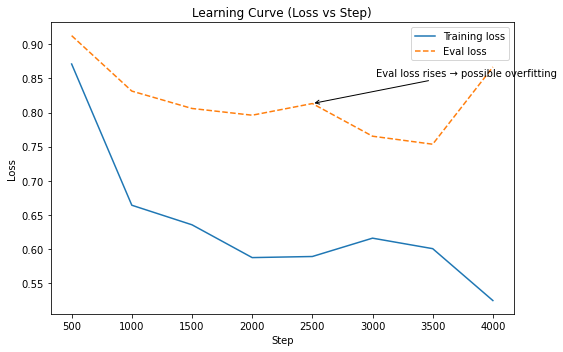

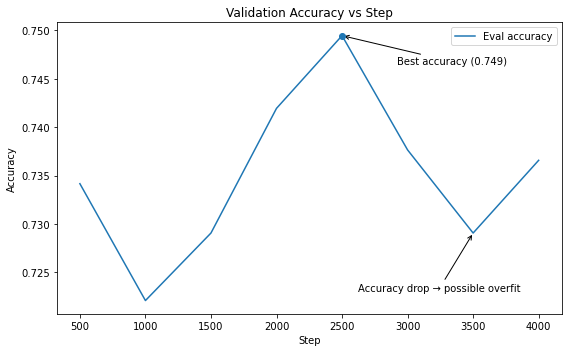

In [154]:
# ---------------- Plots ----------------
# Learning curves 
state = read_trainer_state(MODEL_DIR)
train_df, eval_df = extract_logs_from_state(state)

if train_df.empty and eval_df.empty:
    print("No training/eval logs found in trainer_state.json.")
else:
    # Loss vs Step
    plt.figure(figsize=(8,5))
    if not train_df.empty:
        plt.plot(train_df["step"], train_df["loss"], label="Training loss")
    if not eval_df.empty:
        plt.plot(eval_df["step"], eval_df["eval_loss"], linestyle="--", label="Eval loss")
    
    if rise is not None:
        plt.annotate(
            "Eval loss rises → possible overfitting",
            xy=(rise["step"], rise["loss"]),
            xytext=(rise["step"] + (eval_df["step"].max() - eval_df["step"].min())*0.15, rise["loss"] + 0.04),
            arrowprops=dict(arrowstyle="->")
        )

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Learning Curve (Loss vs Step)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

#Val Accuracy vs Step 
if "eval_accuracy" in eval_df and not eval_df["eval_accuracy"].isna().all():
    steps = eval_df["step"].to_numpy()
    acc   = eval_df["eval_accuracy"].to_numpy()

    plt.figure(figsize=(8,5))
    plt.plot(steps, acc, label="Eval accuracy")

    # Best accuracy point
    best_idx = int(np.nanargmax(acc))
    best_step, best_acc = steps[best_idx], acc[best_idx]
    plt.scatter([best_step], [best_acc], zorder=5)
    plt.annotate(
        f"Best accuracy ({best_acc:.3f})",
        xy=(best_step, best_acc),
        xytext=(best_step + (steps.max()-steps.min())*0.12, best_acc - 0.003),
        arrowprops=dict(arrowstyle="->")
    )

    # If accuracy  dips below the best, annotate a drop
    if best_idx < len(acc) - 1 and np.nanmin(acc[best_idx+1:]) < best_acc - 1e-6:
        drop_idx = best_idx + 1 + int(np.nanargmin(acc[best_idx+1:]))
        drop_step, drop_acc = steps[drop_idx], acc[drop_idx]
        plt.annotate(
            "Accuracy drop → possible overfit",
            xy=(drop_step, drop_acc),
            xytext=(drop_step - (steps.max()-steps.min())*0.25, drop_acc - 0.006),
            arrowprops=dict(arrowstyle="->")
        )
    
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy vs Step")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
else:
    print("No eval_accuracy found in logs; skipping accuracy plot.")




In [155]:
# confusion matrix for the finetunned model

In [162]:
csv_path = "./eval_exports/test_raw_predictions_with_probs.csv"  # optional: CSV with test y_true/y_pred

df = pd.read_csv(csv_path)

In [163]:
df.columns

Index(['true_label_id', 'true_label', 'pred_label_id', 'pred_label',
       'pred_prob', 'second_prob', 'confidence_margin', 'is_error', 'Neutral',
       'body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim'],
      dtype='object')

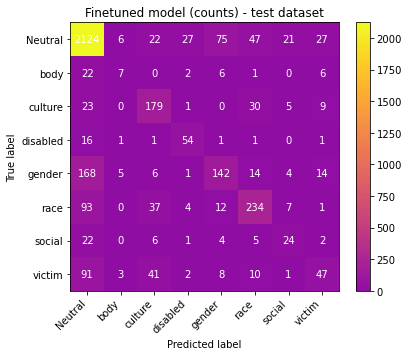

In [164]:


# === 2) Define true labels and predicted labels ===
y_true = df["true_label"].astype(str)
y_pred = df["pred_label"].astype(str)

# Fix label order for consistent confusion matrix axes
labels = sorted(df["true_label"].unique())

# --- lighter purple→yellow colormap ---
def truncated_plasma(low=0.30, high=1.0, n=256):
    base = plt.cm.get_cmap("plasma")
    new_colors = base(np.linspace(low, high, n))
    return mcolors.LinearSegmentedColormap.from_list("plasma_light", new_colors)

# === 3) Create confusion matrix ===
SHOW_NORMALIZED = False  # set True for percentage view

cm_counts = confusion_matrix(y_true, y_pred, labels=labels)

if SHOW_NORMALIZED:
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_plot = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
    cm_plot = np.nan_to_num(cm_plot)  # replaces NaNs from empty rows
    vmin, vmax = 0.0, 1.0
    title = "Confusion Matrix (row-normalized)"
    fmt = ".2f"
else:
    cm_plot = cm_counts
    vmin = None
    vmax = None
    title = "Finetuned model (counts) - test dataset"
    fmt = "d"

# === 4) Plot ===
cmap = truncated_plasma(low=0.30)
plt.figure(figsize=(6,5))
im = plt.imshow(cm_plot, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(title)
plt.colorbar(im)

ticks = np.arange(len(labels_s))
plt.xticks(ticks, labels_s, rotation=45, ha="right")
plt.yticks(ticks, labels_s)

thresh = cm_plot.max() / 2.0 if cm_plot.size else 0
for i in range(cm_plot.shape[0]):
    for j in range(cm_plot.shape[1]):
        val = cm_plot[i, j]
        plt.text(j, i, format(val, fmt), ha="center", va="center", color="white")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [165]:
# confusion mx for the best sweep model with CE 

In [166]:
df_s = pd.read_csv("results_t2835ru3.csv")  # change path if needed

# Extract labels
y_true_s = df["actual_bias_type"]
y_pred_s = df["predicted_bias_type"]

# Define class labels in consistent order
labels_s = sorted(y_true.unique())


KeyError: 'actual_bias_type'

In [167]:
df_s.columns

Index(['post', 'actual_bias_type', 'predicted_bias_type', 'prob_Neutral',
       'prob_body', 'prob_culture', 'prob_disabled', 'prob_gender',
       'prob_race', 'prob_social', 'prob_victim'],
      dtype='object')

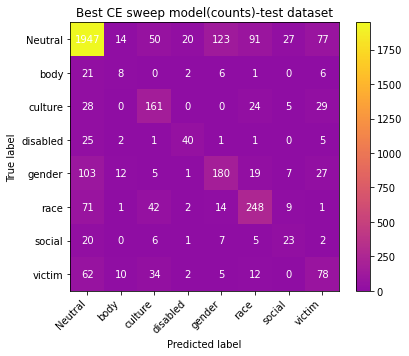

In [126]:
# --- lighter purple→yellow colormap ---
def truncated_plasma(low=0.30, high=1.0, n=256):
    base = plt.cm.get_cmap("plasma")
    new_colors = base(np.linspace(low, high, n))
    return mcolors.LinearSegmentedColormap.from_list("plasma_light", new_colors)

# Inputs: y_true_s, y_pred_s, labels_s must be defined
SHOW_NORMALIZED = False  # set False to show raw counts

# Build the confusion matrix (counts)
cm_counts = confusion_matrix(y_true_s, y_pred_s, labels=labels_s)

# Choose what to plot
if SHOW_NORMALIZED:
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_plot = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
    cm_plot = np.nan_to_num(cm_plot)  # handle any all-zero rows safely
    vmin, vmax = 0.0, 1.0
    title = "Confusion Matrix (row-normalized)"
    fmt = ".2f"
else:
    cm_plot = cm_counts
    vmin = None
    vmax = None
    title = "Best CE sweep model(counts)-test dataset"
    fmt = "d"

# Plot
cmap = truncated_plasma(low=0.30)
plt.figure(figsize=(6,5))
im = plt.imshow(cm_plot, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
plt.title(title)
plt.colorbar(im)

ticks = np.arange(len(labels_s))
plt.xticks(ticks, labels_s, rotation=45, ha="right")
plt.yticks(ticks, labels_s)

# Annotate each cell with the numeric value shown in the image
thresh = cm_plot.max() / 2.0 if cm_plot.size else 0
for i in range(cm_plot.shape[0]):
    for j in range(cm_plot.shape[1]):
        val = cm_plot[i, j]
        plt.text(
            j, i, format(val, fmt),
            ha="center", va="center",
            color="white")# if val > thresh else "black"
        

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [ ]:
# sgnificance test

In [145]:
# Boolean masks for correct/incorrect predictions
ft_correct = df_all['pred_ft'] == df_all['actual']
sw_correct = df_all['pred_sw'] == df_all['actual']  # fixed column name

# Off-diagonal counts (discordant predictions)
n01 = ((~ft_correct) & (sw_correct)).sum()  # Finetuned wrong, Sweep correct
n10 = ((ft_correct) & (~sw_correct)).sum()  # Finetuned correct, Sweep wrong

# McNemar's test via exact binomial
successes = int(n10)  # count where finetuned wins
trials = int(n01 + n10)  # total discordant cases

if trials == 0:
    print("No discordant pairs: models agree on all predictions.")
else:
    res = binomtest(successes, trials, p=0.5, alternative='greater')
    p_one_sided = res.pvalue

    print(f"n01 (Sweep correct, Finetuned wrong): {n01}")
    print(f"n10 (Finetuned correct, Sweep wrong): {n10}")
    print(f"One-sided p-value (H1: Finetuned > Sweep): {p_one_sided:.10f}")

    if p_one_sided < 0.05:
        print("Statistically significant evidence that Finetuned is better.")
    else:
        print("No statistically significant evidence that Finetuned is better.")

n01 (Sweep correct, Finetuned wrong): 174
n10 (Finetuned correct, Sweep wrong): 300
One-sided p-value (H1: Finetuned > Sweep): 0.0000000039
Statistically significant evidence that Finetuned is better.
